## librerias

In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
from preprocessing.data_preprocessing import data_preprocessing
from util.aux_funtions import stat_significance_Correlation, lags_evaluation
#import models
from training.xgboost_regressor import XgboostRegressorModel
from training.nn_regresor import MlpRegressorModel
from training.lasso import LassoModel

from training.train_local import main
from training.auxiliar_functions import evaluate_metrics,select_best_model,obtain_steps,series_to_supervised
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from skforecast.utils import save_forecaster
from joblib import dump, load

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

c:\Users\jmoscoso04\OneDrive - Cementos Argos S.A\Documentos\Proyectos\2B\Macro_2B\code


In [2]:
import os
ROOT_PATH=os.path.abspath(os.path.join(os.path.dirname('__file__')))
# Read config file
DATA_OUT_PATH= os.path.join(ROOT_PATH,'data','output')

## procesamiento de datos

In [3]:
start_date = '2015-01'
end_date = '2022-06'
selected_lags={}
df_out={}

# for c in column:
print(f"****************************data_preprocessing***********************************************")
df_data = data_preprocessing(start_date, end_date)
print(f"****************************stat_significance_Correlation************************************")
features=list(df_data.columns[1:])
stat_significance_Correlation(df_data,features, p_value_limit=0.08)
print(f"****************************lags_evaluation**************************************************")
y_list=list(df_data.columns[:1])
df_selected_lags=lags_evaluation(df_data,y_list)
selected_lags['twobe']=df_selected_lags
# print(df_selected_lags)

****************************data_preprocessing***********************************************
****************************stat_significance_Correlation************************************
amz                       0.914368
federal_funds            -0.334318
apparel_retailers         0.816310
test_10y                 -0.324695
inflation                 0.674462
consumer_discretionary    0.940462
luxury                    0.909449
fed_mp                   -0.304841
Name: corr_pearson, dtype: float64
amz                       0.923722
federal_funds            -0.360828
apparel_retailers         0.806346
test_10y                 -0.356820
inflation                 0.424043
consumer_discretionary    0.948128
luxury                    0.888542
fed_mp                   -0.344687
Name: corr_spearman, dtype: float64
amz                       0.755578
unempl                   -0.148051
federal_funds            -0.149975
apparel_retailers         0.582418
test_10y                 -0.184149
inflat

## Entrenamiento de modelos  con datos de valor acumulados

### mejores lags

### competencia mejor modelo

In [4]:
features = list(df_data.drop(columns=['twobe']).columns)
features = list(df_data.columns)
div = 5
lags_param = 12
winner_acum = main(df_data,features,div,lags_param)

In [27]:
pd.DataFrame(winner_acum).to_csv('scenarios\winner_dict.csv')

### resultado metricas mejor modelo

In [28]:
for m in os.listdir(os.path.join(DATA_OUT_PATH,'training_models')): 
    if 'forecaster_' in m and winner_acum['model_name'] in m:
        # Load model
        forecaster_loaded = load(os.path.join(DATA_OUT_PATH,'training_models',m))
    if 'scaler_X_' in m and winner_acum['model_name'] in m:
        # Load scaler
        scaler_X_loaded = load(os.path.join(DATA_OUT_PATH,'training_models',m))
    if 'scaler_y_' in m and winner_acum['model_name'] in m:
        scaler_y_loaded = load(os.path.join(DATA_OUT_PATH,'training_models',m))

if 'MlpRegressorModel_' in winner_acum['model_name']:
    object_model=MlpRegressorModel()
elif 'XgboostRegressorModel' in winner_acum['model_name']:
    object_model=XgboostRegressorModel()
elif 'LassoModel' in winner_acum['model_name']:
    object_model=LassoModel()

object_model.scaler_X=scaler_X_loaded
object_model.scaler_y=scaler_y_loaded

In [6]:
#create dataset with lags
df_lags = series_to_supervised(df_data[features], n_lags=winner_acum['lags'], n_out=1, dropnan=True)
df = df_lags[df_lags.columns[:-len(features)+1]]
df['mes'] = df.index.month
data_test = df[-div:]     
predictions = object_model.predict_steps(winner_acum['model'],data_test.drop('twobe',axis=1))
eval_metrics = evaluate_metrics(data_test[['twobe']], predictions)

Text(0.5, 1.0, 'prediccion del valor acumulado: LassoModel_12')

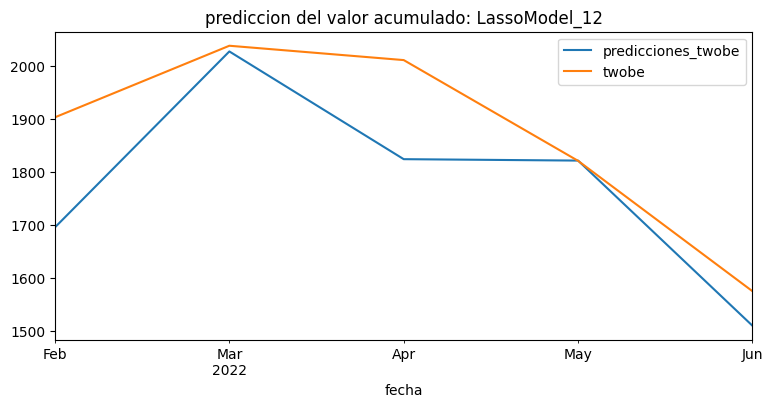

In [7]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
df_grafico_acum=pd.DataFrame([])
df_grafico_acum['predicciones_twobe']=predictions['twobe']
df_grafico_acum['twobe']=data_test[['twobe']]
df_grafico_acum.plot(ax=ax)
ax.legend()
ax.set_title(f'prediccion del valor acumulado: {winner_acum["model_name"]}')

## analisis de sensibilidad

In [8]:
porcentajes_variacion_xi = [0.2,0.1,0,-0.1, -0.2]
xi = df.loc[['2022-02-01']]
columns=list(df.drop('twobe',axis=1).columns)
xi

,twobe_lag_5,amz_lag_5,unempl_lag_5,federal_funds_lag_5,apparel_retailers_lag_5,test_10y_lag_5,gdp_lag_5,inflation_lag_5,consumer_discretionary_lag_5,luxury_lag_5,...,federal_funds_lag_1,apparel_retailers_lag_1,test_10y_lag_1,gdp_lag_1,inflation_lag_1,consumer_discretionary_lag_1,luxury_lag_1,fed_mp_lag_1,twobe,mes
fecha,,,,,,,,,,,,,,,,,,,,,
2022-02-01,1557.033333,171.359143,0.048,0.00079,1216.904762,0.013706,0.023,0.054,1461.767619,4533.517727,...,0.0008,1151.05,0.01759,-0.014,0.075,1511.4035,4704.786667,0.0025,1903.5,2


In [27]:
cambio_twobe_df= pd.DataFrame([])
for c in columns:
    pronostico_twobe_df= pd.DataFrame([])
    for porc_var in porcentajes_variacion_xi:
        nuevo_xi=xi.copy()
        nuevo_xi['porcentaje_var']=porc_var
        nuevo_xi[c]=nuevo_xi[c]*(1+porc_var)
        pronostico_twobe_df=pd.concat([nuevo_xi,pronostico_twobe_df],ignore_index=True)

    predictions=object_model.predict_steps(winner_acum['model'],pronostico_twobe_df.drop(['twobe','porcentaje_var'],axis=1))
    predictions['nuevo_twobe']=predictions['twobe']
    predictions=pd.concat([pronostico_twobe_df,predictions[['nuevo_twobe']]],axis=1)
    predictions['variable']=c
    cambio_twobe_df=pd.concat([cambio_twobe_df,predictions[['twobe','mes','variable','porcentaje_var','nuevo_twobe']]],ignore_index=True)
cambio_twobe_df.head(20)

,twobe,mes,variable,porcentaje_var,nuevo_twobe
0,1903.5,2.0,twobe_lag_5,-0.2,1703.533726
1,1903.5,2.0,twobe_lag_5,-0.1,1699.744253
2,1903.5,2.0,twobe_lag_5,0.0,1695.954781
3,1903.5,2.0,twobe_lag_5,0.1,1692.165309
4,1903.5,2.0,twobe_lag_5,0.2,1688.375836
5,1903.5,2.0,amz_lag_5,-0.2,1483.561207
6,1903.5,2.0,amz_lag_5,-0.1,1589.757994
7,1903.5,2.0,amz_lag_5,0.0,1695.954781
8,1903.5,2.0,amz_lag_5,0.1,1802.151568
9,1903.5,2.0,amz_lag_5,0.2,1908.348355


### grafico de tornado

In [42]:
porcentajes_variacion_xi = [0,0.01]
acum_tornado_df = pd.DataFrame([])
for steps in [x.date().isoformat() for x in df.iloc[-div:].index]:
    xi = df.loc[[steps]]
    for c in columns:
        pronostico_twobe_df = pd.DataFrame([])
        tornado_df = pd.DataFrame([])
        for porc_var in porcentajes_variacion_xi:
            nuevo_xi = xi.copy()
            nuevo_xi['porcentaje_var_in'] = porc_var
            nuevo_xi[c] = nuevo_xi[c]*(1+porc_var)
            pronostico_twobe_df = pd.concat([nuevo_xi,pronostico_twobe_df],ignore_index=True)

        predictions = object_model.predict_steps(winner_acum['model'],pronostico_twobe_df.drop(['twobe','porcentaje_var_in'],axis=1))
        predictions['Xi'] = c
        predictions['pronostico_twobe'] = predictions['twobe']
        
        predictions = pd.concat([pronostico_twobe_df[['twobe','mes','porcentaje_var_in']],predictions[['Xi','pronostico_twobe']]],axis=1)
        
        tornado_df=predictions.iloc[[0]]
        tornado_df['porcentaje_cambio_twobe(%)']=((predictions['pronostico_twobe'].iloc[0]-predictions['pronostico_twobe'].iloc[1])/predictions['pronostico_twobe'].iloc[1])*100
        acum_tornado_df = pd.concat([acum_tornado_df,tornado_df],ignore_index=True)
acum_tornado_df.mes = acum_tornado_df.mes.apply(int)
acum_tornado_df.to_csv(ROOT_PATH+'\scenarios'+'\macro_tornado.csv', index= False )

In [43]:
acum_tornado_df

,twobe,mes,porcentaje_var_in,Xi,pronostico_twobe,porcentaje_cambio_twobe(%)
0,1903.5,2,0.01,twobe_lag_5,1695.575834,-0.022344
1,1903.5,2,0.01,amz_lag_5,1706.574460,0.626177
2,1903.5,2,0.01,unempl_lag_5,1695.954781,0.000000
3,1903.5,2,0.01,federal_funds_lag_5,1695.954781,0.000000
4,1903.5,2,0.01,apparel_retailers_lag_5,1700.143482,0.246982
...,...,...,...,...,...,...
275,1575.5,6,0.01,inflation_lag_1,1510.381921,0.000000
276,1575.5,6,0.01,consumer_discretionary_lag_1,1512.022816,0.108641
277,1575.5,6,0.01,luxury_lag_1,1514.057468,0.243352
278,1575.5,6,0.01,fed_mp_lag_1,1510.381921,0.000000


In [33]:
ROOT_PATH

'c:\\Users\\jmoscoso04\\OneDrive - Cementos Argos S.A\\Documentos\\Proyectos\\2B\\Macro_2B\\code'

### graficar resultados

In [24]:
import plotly.graph_objects as go
%matplotlib inline

def plot_tornado_chart(acum_tornado_df, name_feature):
  Xi = acum_tornado_df['Xi']
  sr1 = acum_tornado_df['porcentaje_cambio_twobe(%)']

  fig = go.Figure()
  fig.add_trace(go.Bar(y=Xi, x=sr1,
                  base=0,
                  marker_color='rgb(158,202,225)',
                  name='Revenue',
                  marker_line_color='rgb(8,48,107)',
                  orientation='h',
                  marker_line_width=1.5,
                  opacity= 0.7,
                  text = sr1,
                  textposition='auto',
                  #texttemplate = "%{x:,s}(M$) "
  ))
  fig.update_layout(
      height=500,
      margin=dict(t=50,l=10,b=10,r=10),
  title_text=f"Analisis de sensibilidad: Grafico de tornado {name_feature}",
  title_font_family="sans-serif",
  #legend_title_text=’Financials’,
  title_font_size = 25,
  title_font_color="darkblue",
  title_x=0.5 #to adjust the position along x-axis of the title
  )
  fig.update_layout(barmode='overlay', 
                    xaxis_tickangle=-45, 
                    legend=dict(
                      x=0.80,
                      y=0.01,
  bgcolor='rgba(255, 255, 255, 0)',
  bordercolor='rgba(255, 255, 255, 0)'
  ),
                    yaxis=dict(
  title=Xi.name,
  titlefont_size=16,
  tickfont_size=14
  ),
  xaxis=dict(
  title=sr1.name,
  titlefont_size=16,
  tickfont_size=14
  ),
  bargap=0.30)
  fig.show()

In [26]:
plot_tornado_chart(acum_tornado_df[acum_tornado_df['mes'] == acum_tornado_df.mes.max()], 'all features mes 6')

In [27]:
df

,twobe_lag_5,amz_lag_5,unempl_lag_5,federal_funds_lag_5,apparel_retailers_lag_5,test_10y_lag_5,gdp_lag_5,inflation_lag_5,consumer_discretionary_lag_5,luxury_lag_5,...,federal_funds_lag_1,apparel_retailers_lag_1,test_10y_lag_1,gdp_lag_1,inflation_lag_1,consumer_discretionary_lag_1,luxury_lag_1,fed_mp_lag_1,twobe,mes
fecha,,,,,,,,,,,,,,,,,,,,,
2016-06-01,326.000000,30.053079,0.049,0.003626,769.421053,0.020794,0.005,0.014,583.945789,1829.755000,...,0.003662,739.619048,0.018022,0.011,0.010,625.030476,1879.246364,0.0050,229.233333,6
2016-07-01,167.241379,26.531000,0.049,0.003740,766.750000,0.017732,0.008,0.010,572.474500,1827.084286,...,0.003768,721.727273,0.016380,0.014,0.010,620.843636,1831.099091,0.0050,191.935484,7
2016-08-01,299.096774,28.618704,0.050,0.003613,823.590909,0.018882,0.011,0.009,614.056818,1957.138261,...,0.003955,762.900000,0.014918,0.029,0.008,641.695500,1860.712381,0.0050,201.677419,8
2016-09-01,308.633333,30.679714,0.050,0.003667,802.095238,0.017942,0.012,0.011,628.180000,1963.726667,...,0.003957,802.434783,0.015598,0.032,0.011,645.180435,1941.459565,0.0050,182.266667,9
2016-10-01,352.129032,34.873690,0.047,0.003662,739.619048,0.018022,0.011,0.010,625.030476,1879.246364,...,0.003948,782.761905,0.016324,0.035,0.015,630.777619,1923.752727,0.0050,169.967742,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-01,1557.033333,171.359143,0.048,0.000790,1216.904762,0.013706,0.023,0.054,1461.767619,4533.517727,...,0.000800,1151.050000,0.017590,-0.014,0.075,1511.403500,4704.786667,0.0025,1903.500000,2
2022-03-01,1615.129032,166.710310,0.046,0.000795,1129.809524,0.015782,0.069,0.062,1497.409048,4623.269524,...,0.000800,1096.105263,0.019297,-0.015,0.079,1428.323158,4526.325000,0.0025,2038.451613,3
2022-04-01,1599.166667,175.880928,0.042,0.000795,1210.047619,0.015552,0.070,0.068,1633.888095,5045.598636,...,0.001996,1000.130435,0.021211,-0.016,0.085,1395.984783,4105.936087,0.0050,2011.400000,4


In [ ]:
var_pron = [0.5, 0.75, 0.9, 1, 1.1, 1.25, 1.5]
# df_macros = pd.concat([real_df_process, pred_df_process], axis = 0)
df_macros = real_df_process[['TRM', 'IPC']]

df_estimaciones_escenarios = pd.DataFrame()
df_macros_esc = pd.DataFrame()
df_macros_esc_ale = pd.DataFrame()
macros_usadas = pd.DataFrame()

for esc_trm, var_trm in enumerate(var_pron):
    pred_df_process_esc_trm = pred_df_process.copy()
    df_macros_esc['TRM'] = pred_df_process_esc_trm['TRM']*var_trm
    pred_df_process_esc_trm['TRM'] = pred_df_process_esc_trm['TRM']*var_trm   
    
    for esc_ipc, var_ipc in enumerate(var_pron):
        pred_df_process_esc_ipc = pred_df_process_esc_trm.copy()
        df_macros_esc['IPC'] = pred_df_process_esc_ipc['IPC']*var_ipc
        pred_df_process_esc_ipc['IPC'] = pred_df_process_esc_ipc['IPC']*var_ipc
        
        df_esc = pd.concat([real_df_process, pred_df_process_esc_ipc], axis = 0)
        df_macros_esc_ale = pd.concat([df_macros, df_macros_esc])
        macros_usadas['TRM_'+str(esc_trm)] = df_macros_esc_ale['TRM']
        macros_usadas['IPC_'+str(esc_ipc)] = df_macros_esc_ale['IPC']
#         df_macros_esc_ale.columns = ['TRM_'+str(esc_trm), 'IPC_'+str(esc_ipc)]
#         macros_usadas = pd.concat([macros_usadas, df_macros_esc_ale], axis = 1)
        
        df_lags = series_to_supervised(df_esc, n_lags=n_lags, n_out=1, dropnan=True)
        df = df_lags[df_lags.columns[:-len(features)+1]]
        df['mes'] = df.index.month
        data_test = df[-div:]     
        predictions = model.predict(data_test.drop('ebitda',axis=1))
        predictions = pd.DataFrame({f'ebitda_trm_{esc_trm}_ipc_{esc_ipc}':predictions})
        predictions.index = data_test.index
        predictions = predictions[predictions.index >= pred_df_process_esc_ipc.index.min()]
        
        df_escenarios = pd.concat([pred_df_process_esc_ipc[['TRM']], pred_df_process_esc_ipc[['IPC']], predictions], axis = 1)
        df_escenarios.rename(columns= {'TRM':'TRM_'+str(esc_trm), 'IPC':'IPC_'+str(esc_ipc)}, inplace = True)
        df_estimaciones_escenarios = pd.concat([df_estimaciones_escenarios, df_escenarios], axis = 1)

In [121]:
df1 = data_valor[-(winner_valor['lags']+div):-div][features]

### Estimaciones Optimistas - Pesimistas

In [166]:
df_probable = data_valor[-div:][features]
df_optimista=df_probable.copy()
df_optimista['infla_año_corrido']=df_optimista['infla_año_corrido']*0.9
df_pesimista=df_probable.copy()
df_pesimista['infla_año_corrido']=df_pesimista['infla_año_corrido']*1.1

df_escenarios_probable=pd.concat([df1,df_probable])
df_escenarios_optimista=pd.concat([df1,df_optimista])
df_escenarios_pesimista=pd.concat([df1,df_pesimista])


In [180]:
df_estimaciones_escenarios=pd.DataFrame([])
for e,d in zip(['probable','optimista','pesimista'],[df_escenarios_probable,df_escenarios_optimista,df_escenarios_pesimista]):
    df_lags=series_to_supervised(d, n_lags=winner_valor['lags'], n_out=1, dropnan=True)
    df=df_lags[df_lags.columns[:-len(features)+1]]
    df['mes']=df.index.month
    data_test=df[-div:]     
    predictions=object_model.predict_steps(winner_valor['model'],data_test.drop('ebitda',axis=1))
    predictions.columns=[f'ebitda_{e}']
    df_estimaciones_escenarios=pd.concat([df_estimaciones_escenarios,predictions],axis=1)
df_estimaciones_escenarios.iloc[[0]]=df_estimaciones_escenarios.iloc[[0]]+data_acum.iloc[[-(div+1)]]['ebitda'][0]
df_estimaciones_escenarios_final=df_estimaciones_escenarios.cumsum()


In [181]:
import plotly.express as px

fig = px.line(df_estimaciones_escenarios_final, x=df_estimaciones_escenarios_final.index, y=df_estimaciones_escenarios_final.columns,
              title='Escenario IPC')
fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y")
fig.show()